<a href="https://colab.research.google.com/github/Taketo-Muroya/Nowcasting-Project/blob/main/Colab/nowcast-5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The nowcasting of economic conditions in Japan using ML

グーグル検索数（失業や貯金などの検索ワードのトレンド）を用いて、景気の動向を予測するPythonコードです。

## Setting Up

In [159]:
pip install pytrends

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [160]:
# Import packages
import re
import os
import sys
import requests
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf

from math import sqrt
from bs4 import BeautifulSoup
from pathlib import Path
from subprocess import call
from keras.regularizers import l2
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

## Target variable: Indexes of Business Conditions (IBC)

まず、景気動向指数をHPからWebスクレイピングで自動取得します。

In [161]:
url = 'https://www.esri.cao.go.jp/jp/stat/di/'
url_index = url + 'di.html'
res = requests.get(url_index)
soup = BeautifulSoup(res.text, 'html.parser')

name = soup.find_all('a', {'target': '_blank'})[2].attrs['href']
input_file_name = url + name
input_file_name

'https://www.esri.cao.go.jp/jp/stat/di/0805ci.xlsx'

In [162]:
#xls book Open (xls, xlsxのどちらでも可能)
input_book = pd.ExcelFile(input_file_name)
#sheet_namesメソッドでExcelブック内の各シートの名前をリストで取得できる
input_sheet_name = input_book.sheet_names
#lenでシートの総数を確認
num_sheet = len(input_sheet_name)
#シートの数とシートの名前のリストの表示
print ("Sheet の数:", num_sheet)
print (input_sheet_name)

Sheet の数: 1
['指数 Indexes']


In [163]:
#DataFrameとしてsheet1枚のデータを読込み
input_sheet_df = input_book.parse(input_sheet_name[0], skiprows=3)
input_sheet_df = input_sheet_df.iloc[62:,[0,4]]
input_sheet_df = input_sheet_df.rename(columns={'Time (Monthly) Code':'time'})
input_sheet_df['time'] = input_sheet_df['time'].astype('int')
ibc = input_sheet_df.astype('float')

# 前年比もデータセットに追加
ibc['Coincident ann'] = 100*ibc['Coincident Index'].pct_change(12)

ibc

,time,Coincident Index,Coincident ann
62,1.985000e+09,79.0,NaN
63,1.985000e+09,78.7,NaN
64,1.985000e+09,78.6,NaN
65,1.985000e+09,79.5,NaN
66,1.985001e+09,79.5,NaN
...,...,...,...
507,2.022000e+09,96.3,5.592105
508,2.022000e+09,96.8,3.198294
509,2.022000e+09,96.8,1.255230
510,2.022001e+09,94.9,1.172708


## Google Trend

グーグル検索数（グーグルトレンド）をAPIを用いて自動取得して、景気動向指数との相関関係を確認します。

In [164]:
# Import packages
from pytrends.request import TrendReq
# plt.rcParams['font.family'] = 'IPAexGothic'

# API Connection
pytrends = TrendReq(hl='ja-JP', tz=360)

Correlation of level: -0.89
Correlation of YoY: -0.77


Text(0.5, 1.0, 'Google Search: "Unemployment"')

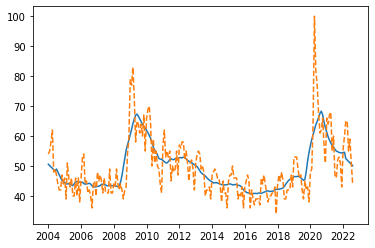

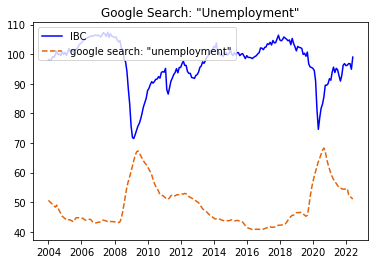

In [165]:
# Set keyword ("失業" = "unemployment")
kw1 = "失業"
kw_list1 = [kw1]
pytrends.build_payload(kw_list1, timeframe='all', geo='JP')
gt1 = pytrends.interest_over_time()
gt1 = gt1.rename(columns = {kw1:"var1", "isPartial":"info"})
#gt1.to_csv("data/gt1.csv")
#dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
#gt1 = pd.read_csv('data/gt1.csv', index_col=0, date_parser=dateparse, dtype='float')

# Extract trend factor
s1 = seasonal_decompose(gt1.iloc[:,0], extrapolate_trend='freq', period=12)
t1 = s1.trend
plt.plot(t1)
plt.plot(gt1.iloc[:,0], linestyle='--')

# Check correlation
level = ibc['Coincident Index'][228:]
level.index = t1[:len(ibc)-228].index
cor = level.corr(t1[:len(ibc)-228])
print("Correlation of level: {:.2f}".format(cor))

a1 = gt1.iloc[:,0].pct_change(12)
ann = ibc['Coincident ann'][228:]
ann.index = a1[:len(ibc)-228].index
cor = ann.corr(a1[:len(ibc)-228])
print("Correlation of YoY: {:.2f}".format(cor))

# Plot trend
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(t1[:len(ibc)-228].index, ibc['Coincident Index'][228:], linestyle='-', color='b', label='IBC')
ax.plot(t1[:len(ibc)-228].index, t1[:len(ibc)-228], linestyle='--', color='#e46409', label='google search: "unemployment"')
ax.legend(loc='upper left')
plt.title('Google Search: "Unemployment"')
#plt.savefig("images/google1.png")

Correlation of level: 0.44
Correlation of YoY: 0.20


Text(0.5, 1.0, 'Google Search: "Saving"')

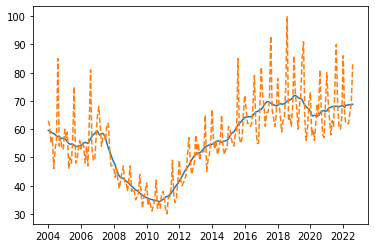

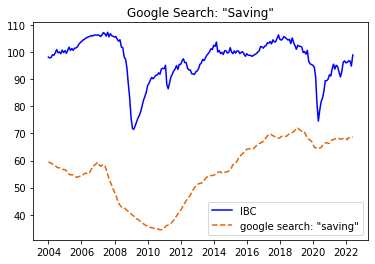

In [166]:
# Set keyword ("貯金" = "saving")
kw2 = "貯金"
kw_list2 = [kw2]
pytrends.build_payload(kw_list2, timeframe='all', geo='JP')
gt2 = pytrends.interest_over_time()
gt2 = gt2.rename(columns = {kw2:"var2", "isPartial":"info"})
#gt2.to_csv("data/gt2.csv")
#dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
#gt2 = pd.read_csv('data/gt2.csv', index_col=0, date_parser=dateparse, dtype='float')

# Extract trend factor
s2 = seasonal_decompose(gt2.iloc[:,0], extrapolate_trend='freq', period=12)
t2 = s2.trend
plt.plot(t2)
plt.plot(gt2.iloc[:,0], linestyle='--')

# Check correlation
level = ibc['Coincident Index'][228:]
level.index = t2[:len(ibc)-228].index
cor = level.corr(t2[:len(ibc)-228])
print("Correlation of level: {:.2f}".format(cor))

a2 = gt2.iloc[:,0].pct_change(12)
ann = ibc['Coincident ann'][228:]
ann.index = a2[:len(ibc)-228].index
cor = ann.corr(a2[:len(ibc)-228])
print("Correlation of YoY: {:.2f}".format(cor))

# Plot trend
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(t2[:len(ibc)-228].index, ibc['Coincident Index'][228:], linestyle='-', color='b', label='IBC')
ax.plot(t2[:len(ibc)-228].index, t2[:len(ibc)-228], linestyle='--', color='#e46409', label='google search: "saving"')
ax.legend()
plt.title('Google Search: "Saving"')
#plt.savefig("images/google2.png")

In [167]:
# Combine google trend (level)
gtrend_l = pd.concat([t1, t2], axis=1)

# Combine google trend (YoY)
gtrend_y = pd.concat([a1, a2], axis=1)

## Time series analysis

景気動向指数とグーグル検索数について、自己相関や単位根、共和分を確認した上で、ARIMA推計を実施します。

In [168]:
# Set time series dataset
X = pd.merge(gtrend_l, gtrend_y, on='date')
y = ibc[228:]
y = y.set_index('time')
y.index = X[:len(ibc)-228].index
ts = pd.merge(y, X, on='date')
ts = ts.set_axis(['Coincident Index', 'Coincident ann', 'var1', 'var2', 
                  'var1_rate', 'var2_rate'], axis='columns')

# Split data into training and test set
sp = round(0.8*len(ts))
train = ts[0:sp]
test = ts[sp:]

ts

,Coincident Index,Coincident ann,var1,var2,var1_rate,var2_rate
date,,,,,,
2004-01-01,98.2,8.508287,50.600233,59.539093,NaN,NaN
2004-02-01,97.9,7.346491,50.144959,59.257916,NaN,NaN
2004-03-01,98.1,7.802198,49.689685,58.976739,NaN,NaN
2004-04-01,99.1,9.502762,49.234411,58.695561,NaN,NaN
2004-05-01,98.9,8.324206,48.779138,58.414384,NaN,NaN
...,...,...,...,...,...,...
2022-02-01,96.3,5.592105,54.583333,67.708333,-0.062500,-0.057143
2022-03-01,96.8,3.198294,52.470862,68.467512,-0.029851,-0.031250
2022-04-01,96.8,1.255230,51.994755,68.535402,-0.044118,0.068966


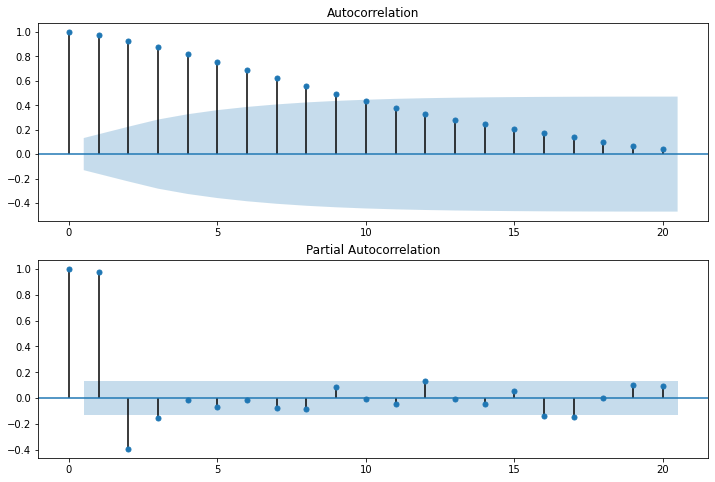

In [169]:
# Check Autocorrelation of IBC
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts['Coincident Index'], lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts['Coincident Index'], lags=20, ax=ax2)
#plt.savefig("images/autocorrelation.png")

In [170]:
# 単位根、共和分を確認していますが、var2については定常ではない可能性

# Unit root test of y (H0: non-stationary)
adf_result = sm.tsa.stattools.adfuller(ts['Coincident Index'])
print("Unit root test (y): {:.2f}".format(adf_result[1])) # p-value

# Take difference of y
diff = ts['Coincident Index'].diff()
diff = diff.dropna()
adf_result = sm.tsa.stattools.adfuller(diff)
print("Unit root test (diff_y): {:.2f}".format(adf_result[1])) # p-value

# Unit root test of X (H0: non-stationary)
adf_result = sm.tsa.stattools.adfuller(ts['var1'])
print("Unit root test (var1): {:.2f}".format(adf_result[1])) # p-value

# Take difference of X
diff = ts['var1'].diff()
diff = diff.dropna()
adf_result = sm.tsa.stattools.adfuller(diff)
print("Unit root test (diff_var1): {:.2f}".format(adf_result[1])) # p-value

# Unit root test of X (H0: non-stationary)
adf_result = sm.tsa.stattools.adfuller(ts['var2'])
print("Unit root test (var2): {:.2f}".format(adf_result[1])) # p-value

# Take difference of X
diff = ts['var2'].diff()
diff = diff.dropna()
adf_result = sm.tsa.stattools.adfuller(diff)
print("Unit root test (diff_var2): {:.2f}".format(adf_result[1])) # p-value

# Cointegration test (H0: non-cointegration)
coint_result = sm.tsa.stattools.coint(ts['Coincident Index'], ts['var1'])
print("Cointegration test (var1): {:.2f}".format(coint_result[1])) # p-value
coint_result = sm.tsa.stattools.coint(ts['Coincident Index'], ts['var2'])
print("Cointegration test (var2): {:.2f}".format(coint_result[1])) # p-value

Unit root test (y): 0.07
Unit root test (diff_y): 0.00
Unit root test (var1): 0.08
Unit root test (diff_var1): 0.02
Unit root test (var2): 0.62
Unit root test (diff_var2): 0.14
Cointegration test (var1): 0.00
Cointegration test (var2): 0.11


### ARIMA Prediction

In [171]:
# Fit the model
SARIMAX = sm.tsa.SARIMAX(train['Coincident Index'], train.iloc[:,2:4], order=(1,1,0), freq='MS').fit()
print(SARIMAX.summary())

                               SARIMAX Results                                
Dep. Variable:       Coincident Index   No. Observations:                  178
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -303.120
Date:                Thu, 25 Aug 2022   AIC                            614.240
Time:                        06:02:50   BIC                            626.945
Sample:                    01-01-2004   HQIC                           619.393
                         - 10-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
var1          -0.7884      0.148     -5.313      0.000      -1.079      -0.498
var2           0.1121      0.255      0.439      0.660      -0.388       0.612
ar.L1          0.1527      0.067      2.284      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


Test set score（決定係数）: 0.44


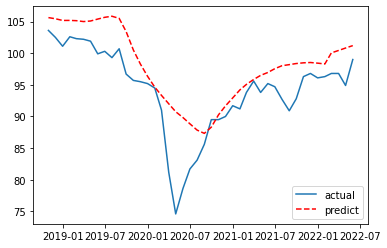

In [172]:
# あまり当てはまりが良くない結果が得られます。

pred = SARIMAX.predict(test.index[0], test.index[-1], exog=test.iloc[:,2:4])
plt.plot(test['Coincident Index'], label="actual")
plt.plot(pred, "r", linestyle='--', label="predict")
plt.legend(loc='lower right')

print("Test set score（決定係数）: {:.2f}".format(r2_score(test['Coincident Index'], pred)))

## Random Forest

機械学習手法の一つであるランダムフォレストを用いて推計を行います。

Training set score: 1.00
Cross-Validation score: 0.58
Test set score（決定係数）: 0.75


Text(0.5, 1.0, 'Random Forest: Level')

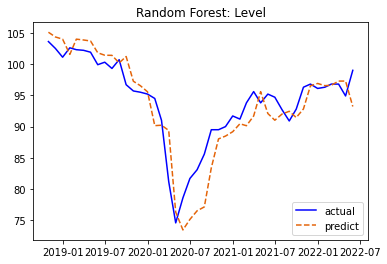

In [173]:
# Set X and y variables
X = ts.iloc[:,2:4]
y = ts['Coincident Index']

# Preprocess for adding AR
X_l = X.drop(X.index[0])
#X_l = X_l.drop(X_l.index[0])
X_l.reset_index(inplace=True, drop=True)

# Generate AR variable
y_l = y.drop(y.index[-1])
#y_l = y_l.drop(y_l.index[-1])
y_l.reset_index(inplace=True, drop=True)

# Add AR into X
X_t = pd.concat([y_l, X_l], axis=1)
y_t = y.drop(y.index[0])
#y_t = y_t.drop(y_t.index[0])
X_t.index = y_t.index

# Split data into training and test set 
sp = round(0.8*len(X_t))
X_train = X_t[0:sp]
X_test = X_t[sp:]
y_train = y_t[0:sp]
y_test = y_t[sp:]

# Fit the model
tm = RandomForestRegressor(n_estimators=1000).fit(X_train, y_train)
#tm.feature_importances_

# Goodness of Fit
print("Training set score: {:.2f}".format(tm.score(X_train, y_train)))
print("Cross-Validation score: {:.2f}".format(
          np.mean(cross_val_score(tm, X_train, y_train, cv=5))))
print("Test set score（決定係数）: {:.2f}".format(tm.score(X_test, y_test)))

# Calculate the prediction
prediction = pd.DataFrame(tm.predict(X_test))
pre = prediction.values.tolist()
act = y_test.values.tolist()
predict = pd.DataFrame(pre, columns=['predict'])
actual = pd.DataFrame(act, columns=['actual'])
com = pd.concat([predict, actual], axis=1)

# Plot the prediction
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(X_test.index, com.actual, linestyle='-', color='b', label='actual')
ax.plot(X_test.index, com.predict, linestyle='--', color='#e46409', label='predict')
ax.legend(loc='lower right')
ax.set_title('Random Forest: Level')
#plt.savefig("images/google_rf.png")

In [174]:
# 各変数の重要度を示しています。
print(tm.feature_importances_)

[0.90030991 0.0748926  0.02479749]


## RNN-LSTM

機械学習手法の一つであるニューラルネットワークにおける長期短期記憶モデルを用いて推計を行います。

In [175]:
# set the dataset
features = pd.concat([ts['Coincident Index'], ts.iloc[:,2:4]], axis=1)
features.tail()

,Coincident Index,var1,var2
date,,,
2022-02-01,96.3,54.583333,67.708333
2022-03-01,96.8,52.470862,68.467512
2022-04-01,96.8,51.994755,68.535402
2022-05-01,94.9,51.518648,68.603293
2022-06-01,99.0,51.042541,68.671183


In [176]:
# set training percentage
TRAIN_SPLIT = round(0.75*len(features))
print(TRAIN_SPLIT)

# feature scaling
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

166


In [177]:
def multivariate_data(dataset, target, start_index, end_index, 
                      history_size, target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    # add current dataset
    indices = range(i-history_size, i+1, step)
    temp = pd.DataFrame(dataset[indices])
    # replace current target to previous one
    temp.iat[history_size, 0] = temp.iat[history_size-1, 0]
    data.append(np.array(temp))

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [178]:
# create the training and test data

past_history = 2
future_target = 0
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:,0], 0, TRAIN_SPLIT, past_history, future_target, STEP, single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:,0], TRAIN_SPLIT, None, past_history, future_target, STEP, single_step=True)

In [179]:
pd.DataFrame(dataset).head(7)

,0,1,2
0,0.070640,0.400937,0.770040
1,0.031202,0.332037,0.742151
2,0.057494,0.263137,0.714261
3,0.188955,0.194237,0.686372
4,0.162663,0.125337,0.658482
5,0.280977,0.056438,0.630592
6,0.438730,0.158762,0.580184


In [180]:
# ２期前までの景気動向指数とグーグル検索数のデータを用いて、

pd.DataFrame(x_train_single[0])

,0,1,2
0,0.070640,0.400937,0.770040
1,0.031202,0.332037,0.742151
2,0.031202,0.263137,0.714261


In [181]:
# 当該期の景気動向指数を推計するというモデルを組んでいます。

y_train_single[0]

0.05749416278184816

In [182]:
BATCH_SIZE = 32
BUFFER_SIZE = 100

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [183]:
# construct the model

single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(8, input_shape=x_train_single.shape[-2:]))
#single_step_model.add(tf.keras.layers.LSTM(8, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
#single_step_model.add(tf.keras.layers.LSTM(8, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
#single_step_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(4)))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss='mae')

In [184]:
# train the model
single_step_history = single_step_model.fit(train_data_single, epochs=30, steps_per_epoch=200, validation_data=val_data_single, validation_steps=50)

Epoch 1/30
200/200 [==============================] - 8s 14ms/step - loss: 0.5498 - val_loss: 0.6581
Epoch 2/30
200/200 [==============================] - 2s 8ms/step - loss: 0.5000 - val_loss: 0.6293
Epoch 3/30
200/200 [==============================] - 2s 8ms/step - loss: 0.4565 - val_loss: 0.5982
Epoch 4/30
200/200 [==============================] - 2s 10ms/step - loss: 0.4248 - val_loss: 0.5628
Epoch 5/30
200/200 [==============================] - 1s 7ms/step - loss: 0.3980 - val_loss: 0.5268
Epoch 6/30
200/200 [==============================] - 2s 8ms/step - loss: 0.3792 - val_loss: 0.4939
Epoch 7/30
200/200 [==============================] - 2s 8ms/step - loss: 0.3622 - val_loss: 0.4590
Epoch 8/30
200/200 [==============================] - 2s 8ms/step - loss: 0.3453 - val_loss: 0.4301
Epoch 9/30
200/200 [==============================] - 2s 8ms/step - loss: 0.3311 - val_loss: 0.3992
Epoch 10/30
200/200 [==============================] - 1s 7ms/step - loss: 0.3186 - val_loss: 0.37

In [185]:
def model_eval_metrics(y_true, y_pred, classification="TRUE"):
     if classification=="TRUE":
        accuracy_eval = accuracy_score(y_true, y_pred)
        f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
        precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
        recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
        mse_eval = 0
        rmse_eval = 0
        mae_eval = 0
        r2_eval = 0
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 
                      'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 
                      'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     else:
        accuracy_eval = 0
        f1_score_eval = 0
        precision_eval = 0
        recall_eval = 0
        mse_eval = mean_squared_error(y_true, y_pred)
        rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
        mae_eval = mean_absolute_error(y_true, y_pred)
        r2_eval = r2_score(y_true, y_pred)
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 
                      'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 
                      'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     return finalmetricdata

In [186]:
# evaluate the model
model_eval_metrics(y_val_single, single_step_model.predict(x_val_single), classification="FALSE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0,0,0,0,0.164443,0.405516,0.30067,0.819798


Test set score（決定係数）: 0.82


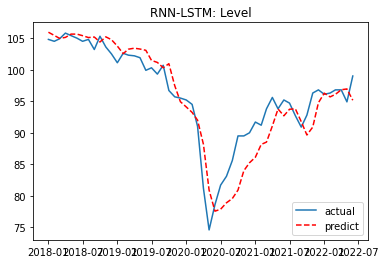

In [187]:
# visualize the result

predict = pd.DataFrame(single_step_model.predict(x_val_single)*data_std[0]+data_mean[0])
predict.index = features.iloc[TRAIN_SPLIT+past_history:,:].index

actual = pd.DataFrame(y_val_single*data_std[0]+data_mean[0])
actual.index = features.iloc[TRAIN_SPLIT+past_history:,:].index

plt.plot(features.iloc[TRAIN_SPLIT+past_history:,0], label="actual")
plt.plot(predict, "r", linestyle='--', label="predict")
plt.legend(loc='lower right')
plt.title('RNN-LSTM: Level')
#plt.savefig("images/google_lstm.png")

print("Test set score（決定係数）: {:.2f}".format(r2_score(y_val_single, single_step_model.predict(x_val_single))))


## Weekly Nowcasting

最後に、上記のモデルで構築したグーグル検索数と景気動向指数の関係性に対して、週次のデータを当てはめることで、足下までの景気動向指数をナウキャスティングします。

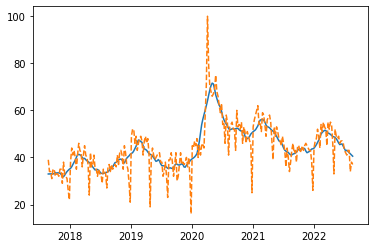

In [188]:
# Get the weekly google trend data (unemployment)
pytrends.build_payload(kw_list1, timeframe='today 5-y', geo='JP')
gt3 = pytrends.interest_over_time()
gt3 = gt3.rename(columns = {kw1: "var1", "isPartial": "info"})
#gt3.to_csv("data/gt3.csv")
#dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
#gt3 = pd.read_csv('data/gt3.csv', index_col=0, date_parser=dateparse, dtype='float')

# Extract trend factor
s3 = seasonal_decompose(gt3.iloc[:,0], extrapolate_trend='freq', period=12)
t3 = s3.trend

plt.plot(t3)
plt.plot(gt3.iloc[:,0], linestyle='--')

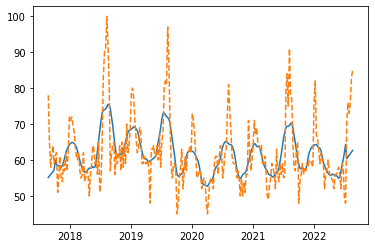

In [189]:
# Get the weekly google trend data (saving)
pytrends.build_payload(kw_list2, timeframe='today 5-y', geo='JP')
gt4 = pytrends.interest_over_time()
gt4 = gt4.rename(columns = {kw2: "var2", "isPartial": "info"})
#gt4.to_csv("data/gt4.csv")
#dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
#gt4 = pd.read_csv('data/gt4.csv', index_col=0, date_parser=dateparse, dtype='float')

# Extract trend factor
s4 = seasonal_decompose(gt4.iloc[:,0], extrapolate_trend='freq', period=12)
t4 = s4.trend

plt.plot(t4)
plt.plot(gt4.iloc[:,0], linestyle='--')

In [190]:
# データをすべて週次に変換します。

temp1 = ts
temp1['monthly'] = ts.index.year.astype('str') + '-' + ts.index.month.astype('str')
temp2 = pd.merge(t3, t4, on='date')
temp2['monthly'] = temp2.index.year.astype('str') + '-' + temp2.index.month.astype('str')
temp3 = temp1.reset_index().set_index('monthly')
temp4 = temp2.reset_index().set_index('monthly')
temp5 = pd.merge(temp3, temp4, on='monthly', how='right')
XX = temp5[['date_y','Coincident Index','trend_x','trend_y']].set_index('date_y')
XX

,Coincident Index,trend_x,trend_y
date_y,,,
2017-08-27,104.6,32.970765,55.144862
2017-09-03,103.8,32.988102,55.559198
2017-09-10,103.8,33.005439,55.973533
2017-09-17,103.8,33.022776,56.387869
2017-09-24,103.8,33.040113,56.802205
...,...,...,...
2022-07-24,NaN,42.548902,60.828817
2022-07-31,NaN,42.045260,61.291521
2022-08-07,NaN,41.541618,61.754225


Text(0.5, 1.0, 'RNN-LSTM: weekly')

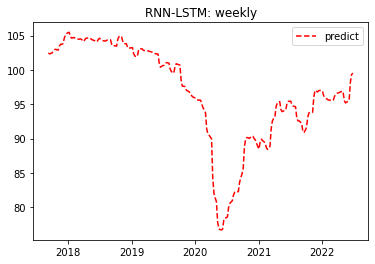

In [191]:
# まず過去の景気動向指数について、週次のグーグル検索数による推計を行います。

# feature scaling
END = len(XX)-XX['Coincident Index'].isnull().sum()
dataset = XX.iloc[:END,:].values
data_mean = dataset.mean(axis=0)
data_std = dataset.std(axis=0)
dataset = (dataset-data_mean)/data_std

# create the test data
past_history = 2
future_target = 0
STEP = 1
x_single, y_single = multivariate_data(dataset, dataset[:,0], 0, None, past_history, future_target, STEP, single_step=True)

# save the output
past_estimate = pd.DataFrame(single_step_model.predict(x_single)*data_std[0]+data_mean[0])
past_estimate.index = XX.iloc[past_history:END,:].index

# visualize the result 
plt.plot(past_estimate, "r", linestyle='--', label="predict")
plt.legend(loc='best')
plt.title('RNN-LSTM: weekly')
#plt.savefig("images/google_lstm.png")


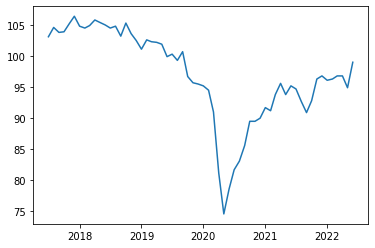

In [192]:
# compare to IBC graph
plt.plot(ts.iloc[len(ts)-5*12:,0:1])

In [193]:
# 景気動向指数がまだ公表されていない期間について、ナウキャスティングを行います。

# nowcast the future IBC
for i in range(END, len(XX)):
  XX.iat[i,0] = float(single_step_model.predict(x_single)[-1]*data_std[0]+data_mean[0])
  #XX.iat[i,0] = XX.iat[i-1,0]
  temp = XX.iloc[:i+1,:]
  print(temp.tail())
  print('-----------------------------------------------')

  # feature scaling
  dataset = temp.values
  data_mean = dataset.mean(axis=0)
  data_std = dataset.std(axis=0)
  dataset = (dataset-data_mean)/data_std
  
  # create the test data
  x_single, y_single = multivariate_data(dataset, dataset[:,0], 0, None, past_history, future_target, STEP, single_step=True)

  XX.iat[i,0] = float(single_step_model.predict(x_single)[-1]*data_std[0]+data_mean[0])
  print(XX.tail(10))
  print('-----------------------------------------------')

# save the output
future_estimate = pd.DataFrame(XX.iloc[END:len(XX)+1,0])

            Coincident Index    trend_x    trend_y
date_y                                            
2022-06-05         99.000000  45.458333  55.291667
2022-06-12         99.000000  45.666667  57.000000
2022-06-19         99.000000  45.708333  58.708333
2022-06-26         99.000000  44.708333  60.250000
2022-07-03         99.542213  43.666667  62.166667
-----------------------------------------------
            Coincident Index    trend_x    trend_y
date_y                                            
2022-06-19         99.000000  45.708333  58.708333
2022-06-26         99.000000  44.708333  60.250000
2022-07-03         99.716743  43.666667  62.166667
2022-07-10               NaN  42.750000  64.375000
2022-07-17               NaN  43.052545  60.366113
2022-07-24               NaN  42.548902  60.828817
2022-07-31               NaN  42.045260  61.291521
2022-08-07               NaN  41.541618  61.754225
2022-08-14               NaN  41.037976  62.216929
2022-08-21               NaN  40.5

Text(0.5, 1.0, 'RNN-LSTM: weekly + nowcast')

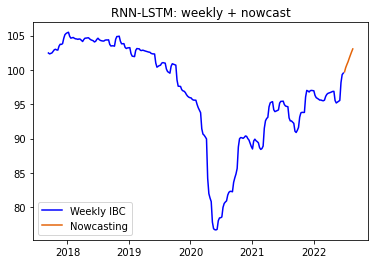

In [194]:
# 推計結果を図示しています。

df_concat = pd.concat([past_estimate.set_axis(['Coincident Index'], axis='columns'), future_estimate])
plt.plot(past_estimate, linestyle='-', color='b', label='Weekly IBC')
plt.plot(future_estimate, linestyle='-', color='#e46409', label='Nowcasting')
plt.legend(loc='lower left')
plt.title('RNN-LSTM: weekly + nowcast')
#plt.savefig("images/google_lstm.png")